# 实验四：朴素贝叶斯分类器
- 姓名：徐文斌
- 学号：2010234
- 专业：计算机科学与技术

## 实验要求

### 基本要求
a) 采用分层采样的方式将数据集划分为训练集和测试集。 b) 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。
### 中级要求
使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。
### 高级要求
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。

## 基本要求

### 数据读取

In [1]:
import math
import numpy as np  
import pandas as pd
import random
import copy
import math
import matplotlib.pyplot as plt

f = open('wine.data','r')
types = [[],[],[]]                      #按类分的所有数据
data_num = 0                            #数据总数
test_len = []    #测试集里每一类的个数

myline = '1'
while myline:
    myline = f.readline().split(',')
    if len(myline) != 14:
        break
    for t in range(len(myline)):
        if t == 0:
            myline[t] = int(myline[t])
        else:
            myline[t] = float(myline[t])
    temp = myline.pop(0)
    types[temp - 1].append(myline)
test_len = [round(len(types[i]) / 5) for i in range(3)]
data_num = sum([len(types[i]) for i in range(3)])

### 分层抽样(4:1)

In [2]:
test_data = [[],[],[]]
train_data = [[],[],[]]
print("数据类别\t测试数据个数\t训练数据个数")
for i in range(3):
    data = copy.deepcopy(types[i])
    for j in range(test_len[i]):
        test_data[i].append(data.pop())
        random.shuffle(data)
    train_data[i].extend(data)
    print(f"{i + 1}\t\t{len(test_data[i])}\t\t{len(train_data[i])}")
p_ck = [len(train_data[i]) / sum([len(train_data[j]) for j in range(3)]) for i in range(3)]
print("P(ck)为:", p_ck)

数据类别	测试数据个数	训练数据个数
1		12		47
2		14		57
3		10		38
P(ck)为: [0.33098591549295775, 0.4014084507042254, 0.2676056338028169]


### 朴素贝叶斯分类器

In [3]:
# 计算高斯概率密度函数
def gauss_function(x, mean, std):
    exponent = np.exp(-(np.power(x - mean, 2))/(2 * np.power(std, 2)))
    GaussProb = (1 / (np.sqrt(2 * np.pi) * std)) * exponent
    return GaussProb

In [4]:
# 计算P(x|ck)
def cal_likely(inst, mean, std):
    result = 0
    for i in range(len(inst)):
        result += math.log(gauss_function(inst[i], mean[i], std[i]))
    return result

In [5]:
def bayes_classificate():
    # 首先，分别计算训练集上三个类的均值和标准差
    scores = [] # 这个用来画roc
    means = [[],[],[]]                       #每一类的均值
    stds = [[],[],[]]                        #每一类的标准差
    confu = np.zeros((3, 3)) # 混淆矩阵
    for i in range(3):
        mean = [0 for j in range(len(train_data[i][0]))]
        std = [0 for j in range(len(train_data[i][0]))]
        inst_num = len(train_data[i])
        for inst in train_data[i]:
            for j in range(len(inst)):
                mean[j] += inst[j]
        for j in range(len(mean)):
            mean[j] /= inst_num
        means[i] = mean
        for inst in train_data[i]:
            for j in range(len(inst)):
                std[j] += (inst[j] - mean[j]) ** 2
        for j in range(len(std)):
            std[j] /= inst_num
            std[j] = np.sqrt(std[j])
        stds[i] = std
    wrong_num = 0
    for i in range(3):
        for t in test_data[i]:                  #两层循环：从每一类取每一个测试样本
            my_type = []
            for j in range(3):
                #由于数据集中所有的属性都是连续值，连续值的似然估计可以按照高斯分布来计算：
                temp = cal_likely(t, means[j], stds[j]) + math.log(p_ck[j])
                my_type.append(temp)                        #这里将所有score保存
            pre_type = my_type.index(max(my_type))          #取分值最大的为预测类别
            confu[i][pre_type] += 1
            my_type.append(i)
            scores.append(my_type)
            if pre_type != i:                               #统计错误数
                wrong_num += 1
    return wrong_num, confu, scores

In [6]:
wn, cf, sc = bayes_classificate()
print(f"分类错误个数：{wn}")

分类错误个数：2


## 中级要求

### 混淆矩阵

In [7]:
cf

array([[10.,  2.,  0.],
       [ 0., 14.,  0.],
       [ 0.,  0., 10.]])

### 得到各个指标

In [8]:
def get_feature(confuse_maxtria):
    total_num = 0
    for i in range(3):
        total_num += sum(confuse_maxtria[i])
    TP = [0, 0, 0]
    FP = [0, 0, 0]
    FN = [0, 0, 0]
    TN = [0, 0, 0]
    for i in range(3):
        TP[i] += confuse_maxtria[i][i]
        for j in range(3):
            if i == j:
                continue
            FP[i] += confuse_maxtria[j][i]
            FN[i] += confuse_maxtria[i][j]
        TN[i] = total_num - TP[i] - FP[i] - FN[i]
    for i in range(3):
        precision = TP[i] / (TP[i] + FP[i])
        recall = TP[i] / (TP[i] + FN[i])
        f_rate = 2 * precision * recall / (precision + recall)
        print(f"第{i + 1}类精度：{precision}，召回率：{recall}，F值：{f_rate}")
    return TP, FP, FN, TN

In [9]:
TP, FP, FN, TN = get_feature(cf)

第1类精度：1.0，召回率：0.8333333333333334，F值：0.9090909090909091
第2类精度：0.875，召回率：1.0，F值：0.9333333333333333
第3类精度：1.0，召回率：1.0，F值：1.0


## 高级要求

### 计算fpr,tpr,auc函数

In [10]:
def roc_curve(scores, categ):
    # 先算fpr和tpr
    fpr = []
    tpr = []
    p_s = [i for i in scores if i[3] == categ]
    n_s = [i for i in scores if i[3] != categ]
    postive_num = len(p_s)
    negative_num = len(n_s)
    for i in scores:        
        threshold = i[categ]
        fp_num = 0
        tp_num = 0
        for j in p_s:
            if j[categ] >= threshold:
                tp_num += 1
        for j in n_s:
            if j[categ] >= threshold:
                fp_num += 1
        fpr.append(fp_num / negative_num)
        tpr.append(tp_num / postive_num)
    fpr.append(0)
    tpr.append(0)
    # 再算auc
    auc = 0.0
    for i in p_s:
        for j in n_s:
            if i[categ] > j[categ]:
                auc += 1
            elif i[categ] == j[categ]:
                auc += 0.5
    auc /= (postive_num * negative_num)
    return fpr, tpr, auc

### 绘图函数

In [11]:
def draw_roc(sc, categ):
    # 先得到fpr, tpr, auc
    sc = sorted(sc, key=lambda x: x[categ])
    fpr, tpr, auc = roc_curve(sc, categ)
    # 再画图
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, '#9400D3',label=u'AUC = %0.3f'% auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(linestyle='-.')  
    plt.grid(True)
    plt.show()
    print(f"第{categ + 1}类的auc为{auc}")

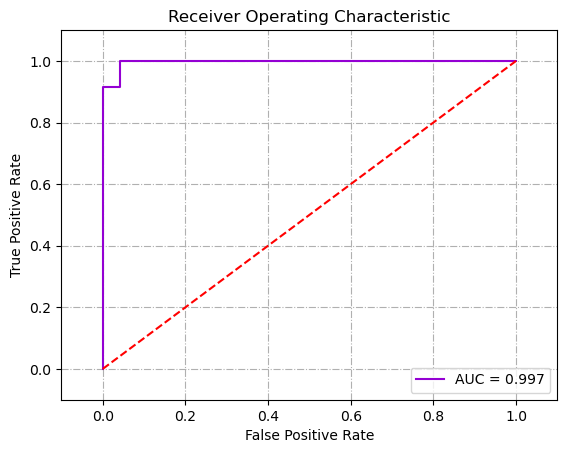

第1类的auc为0.9965277777777778


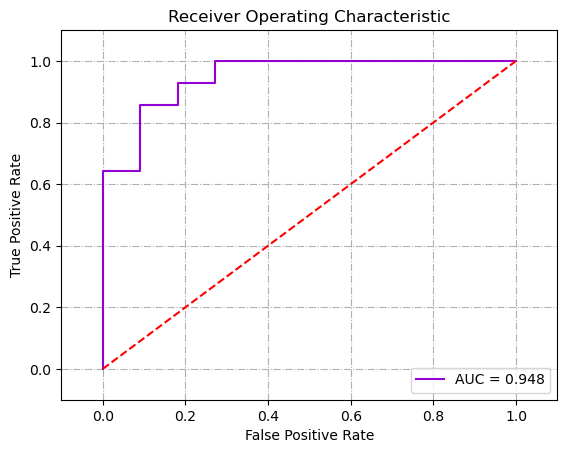

第2类的auc为0.948051948051948


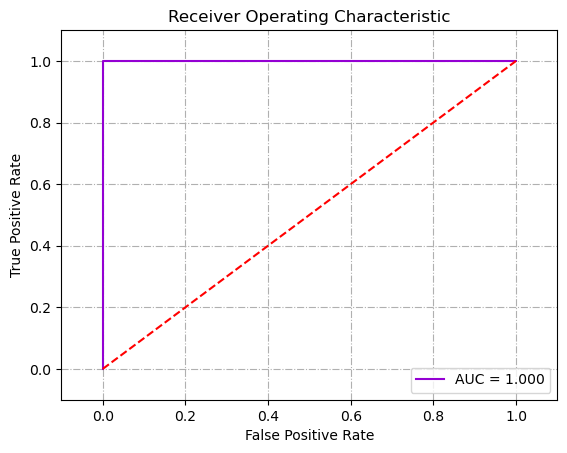

第3类的auc为1.0


In [12]:
draw_roc(sc, 0)
draw_roc(sc, 1)
draw_roc(sc, 2)